In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from sklearn.metrics import confusion_matrix

%matplotlib inline

plt.style.use('ggplot')

In [2]:
def switch_labels(x):
    return x.apply(lambda x: (x-1)*-1)

In [3]:
def plot_results(targets,predictions,title,schema='a'):
    
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    tn, fp, fn, tp = confusion_matrix(targets,predictions).ravel()

    N_pre = tn/(tn+fn)
    N_rec = tn/(tn+fp)
        
    P_pre = tp/(tp+fp)
    P_rec = tp/(tp+fn)

    pre = [N_pre,P_pre]
    rec = [N_rec,P_rec]
    
    if schema == 'a':
        color1 = '#0085f9'
        color2 = '#00176d'
        
    if schema == 'b':
        color1 = '#00ddff'
        color2 = '#00176d'
        
    if schema == 'c':
        color1 = '#00fff2'
        color2 = '#001e14'
    
    if schema == 'd':
        color1 = '#00ffb2'
        color2 = '#000c00'

    k = 0.05
    ax.bar([2+k,5+k],pre,color=color1)
    ax.bar([3-k,6-k],rec,color=color2)
    ax.set_xticks([2.5,5.5])
    ax.set_xticklabels(['Defaulted','Paid Off'],fontsize=14)
    ax.set_xlim([1,7])
    ax.set_ylim([0,1.3])
    ax.legend(['Precision','Recall'],fontsize=12)
    ax.set_title(title,fontsize=16)

    plt.tight_layout()

In [4]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [5]:
loans = select('SELECT * FROM LOAN_FINAL')
loans = loans.drop('index',axis=1)

In [6]:
# separating the data into the first general problem at hand: "Matured Loans" 

loans = loans[(loans['loan_status']=='Charged Off') | (loans['loan_status']=='Fully Paid')].copy()
features = loans.drop('loan_status',axis=1).copy()
targets = loans['loan_status'].copy()

In [7]:
# map targets to 0/1 and perform train-test split on the data. test set to be untouched until final application of models

outputmap = {'Charged Off':0,'Fully Paid':1}
targets = targets.apply(lambda x: outputmap[x])

from sklearn.model_selection import train_test_split

features_train, features_test, targets_train, targets_test = train_test_split(features,targets,random_state=12,test_size=0.2)

In [8]:
# develop lists which split up features into numerical and non-numerical values

numerical = []
strings = []

for i in range(len(loans.dtypes)):
    if (loans.dtypes[i] == 'int64') or (loans.dtypes[i] == 'float64'):
        numerical = numerical + [loans.dtypes.index[i]]
        
    if (loans.dtypes[i] == 'O') and (loans.dtypes.index[i]!='loan_status'):
        strings = strings + [loans.dtypes.index[i]]

In [9]:
numerical_all = list(numerical)

In [10]:
# contain NaN values need to figure out how to translate the meaning implied by NaN in these columns
# member_id has no predictive value
# removing features containing values which may not be known at time of loan origination (otherwise problem is trivial)
# last three are unnecessary from this problem's standpoint

numerical_all.remove('mths_since_last_delinq')
numerical_all.remove('mths_since_last_major_derog')
numerical_all.remove('member_id')

numerical.remove('mths_since_last_delinq')
numerical.remove('mths_since_last_major_derog')
numerical.remove('member_id')
numerical.remove('delinq_2yrs')
numerical.remove('inq_last_6mths')
numerical.remove('out_prncp')
numerical.remove('out_prncp_inv')
numerical.remove('total_pymnt')
numerical.remove('total_pymnt_inv')
numerical.remove('total_rec_prncp')
numerical.remove('total_rec_int')
numerical.remove('total_rec_late_fee')
numerical.remove('recoveries')
numerical.remove('collection_recovery_fee')
numerical.remove('last_pymnt_amnt')
numerical.remove('collections_12_mths_ex_med')
numerical.remove('tot_coll_amt')
numerical.remove('mths_since_issue')
numerical.remove('mths_left')
numerical.remove('%_term_completed')

In [11]:
print(numerical)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'policy_code', 'acc_now_delinq']


### - ASIDE -

In [12]:
# model performs extremely well when using all features. need to strip away those that give obvious
# 'hints' to our model about whether the loan will be charged off. (e.g. recoveries, collection recovery fee, etc..)
# otherwise the problem is fairly trivial...we do not consider this case past this block of code and the next
# remove revol_util and tot_coll_amt... these cols have NaN values that will be filled on the actual model

numerical_all.remove('revol_util')
numerical_all.remove('tot_coll_amt')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
    
lr_all = LogisticRegression()
lr_all.fit(features_train[numerical_all],targets_train)
print(accuracy_score(lr_all.predict(features_test[numerical_all]),targets_test))

0.997246106907


In [13]:
# with all features, even a simple logistic regression performs almost perfectly. this problem is trivial, however

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('TRAIN'+classification_report(targets_train,lr_all.predict(features_train[numerical_all])))
print('TEST'+classification_report(targets_test,lr_all.predict(features_test[numerical_all])))

TRAIN             precision    recall  f1-score   support

          0       1.00      0.99      0.99     35780
          1       1.00      1.00      1.00    166114

avg / total       1.00      1.00      1.00    201894

TEST             precision    recall  f1-score   support

          0       1.00      0.98      0.99      8929
          1       1.00      1.00      1.00     41545

avg / total       1.00      1.00      1.00     50474



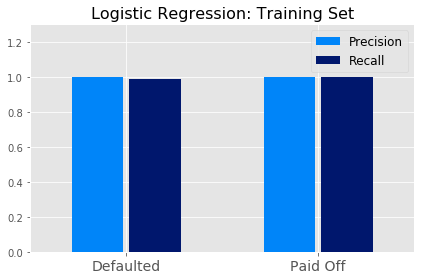

In [14]:
plot_results(targets_train,lr_all.predict(features_train[numerical_all]),'Logistic Regression: Training Set',schema='a')

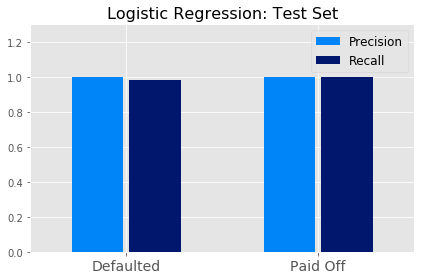

In [15]:
plot_results(targets_test,lr_all.predict(features_test[numerical_all]),'Logistic Regression: Test Set')

In [16]:
# groups dataset into categorically similar subsets and gathers their means for value filling
# this function is specific to this application..may be worth further generalizing

# we can re-write this with .apply() to eliminate the need for the for-loop. if there were a greater magnitude of 
# missing values, this would not be a feasible approach

def NaN_estimator(dataframe,column):
    
    filled_dataframe = dataframe.copy()

    datasubset = dataframe[['grade','home_ownership','initial_list_status','purpose',column]].copy()
    means = datasubset.groupby(by=['grade','home_ownership','initial_list_status','purpose']).mean()

    subset_estimates = []

    for i in dataframe[dataframe[column].isnull()].index:
    
        tuple_temp = (dataframe.loc[i,'grade'],dataframe.loc[i,'home_ownership'],
                      dataframe.loc[i,'initial_list_status'],dataframe.loc[i,'purpose'])
    
        subset_estimates = subset_estimates + [means.loc[tuple_temp,column]]
    
    filled_dataframe.loc[list(dataframe[dataframe[column].isnull()].index),column] = subset_estimates
    
    return filled_dataframe.copy()

In [17]:
# proportions of missing data

print(features_train.isnull().sum().loc['revol_util']/len(features_train))
print(features_train.isnull().sum().loc['tot_coll_amt']/len(features_train))

0.00074791722389
0.251166453684


In [18]:
# use the mean of a a more general ("less similar") subset for remaining null values which have no
# other filled data points in the same subset to estimate from. 
# we can incorporate this process into the function, and take better means

features_train = NaN_estimator(features_train,'revol_util')
features_train.loc[features_train[features_train.revol_util.isnull()].index,'revol_util'] = features_train.revol_util.mean()

features_test = NaN_estimator(features_test,'revol_util')
features_test.loc[features_test[features_test.revol_util.isnull()].index,'revol_util'] = features_test.revol_util.mean()

In [19]:
# there remain 3000 null values. again, use a more general avergae

features_train = NaN_estimator(features_train,'tot_coll_amt')
features_train.loc[features_train[features_train.tot_coll_amt.isnull()].index,'tot_coll_amt'] = \
    features_train.tot_coll_amt.mean()

features_test = NaN_estimator(features_test,'tot_coll_amt')
features_test.loc[features_test[features_test.tot_coll_amt.isnull()].index,'tot_coll_amt'] = \
    features_test.tot_coll_amt.mean()

In [20]:
# write the train/test feature/target data to sql tables to simulate real life scenario from this point onwards in the project
# (in reality, would need to do the NaN_estimator call after this, but it makes no end difference)

# conn = sqlite3.connect('.\data\lending-club-loan-data\database2.sqlite')
# features_train[numerical].to_sql('features_train',conn,index=False)
# targets_train.to_frame().to_sql('targets_train',conn,index=False)
# features_test[numerical].to_sql('features_test',conn,index=False)
# targets_test.to_frame().to_sql('targets_test',conn,index=False)
# conn.close()

In [21]:
loans.loan_status = loans.loan_status.apply(lambda x: outputmap[x])

In [22]:
# note that we artificially encode numerical values to paid off / charged off...there is some loss of interpretibility,
# but the correlations are still reflective of the features' relationships to the output

# not too many features have a strong pos/neg correlation w/ the target variable. the two that stand out the most are 
# the grade (obvious...) and the interest rate (also obvious...)

# the data set is very noisy -- not too many clear indicators for the loan status

loans[numerical+['loan_status']].corr()['loan_status'].sort_values(ascending=False)

loan_status        1.000000
grade              0.224857
annual_inc         0.058788
total_acc          0.032138
revol_bal          0.004081
emp_length         0.003112
pub_rec           -0.001693
acc_now_delinq    -0.006127
open_acc          -0.010523
installment       -0.044067
funded_amnt_inv   -0.056383
funded_amnt       -0.057922
loan_amnt         -0.058070
revol_util        -0.098314
dti               -0.111863
term              -0.151480
int_rate          -0.237576
policy_code             NaN
Name: loan_status, dtype: float64

In [23]:
print(len(loans[loans.loan_status==0]))
print(len(loans[loans.loan_status==1]))

44709
207659


---
## Baseline Model and Evaluation

In [24]:
# training set summary stats of major features in positive classes - FULLY PAID

features_train[targets_train.astype(bool)].describe().loc[['mean','std','min','max']][numerical]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,acc_now_delinq
mean,13334.005713,13295.808902,13210.855622,40.615096,13.270586,412.963107,5.344968,5.838912,7.416339e+04,16.130745,10.910387,0.143125,15198.835047,53.212938,25.207147,1.0,0.002902
std,8061.686950,8040.919810,8057.744844,9.458527,4.266084,244.388445,1.284869,3.556509,6.135407e+04,7.695295,4.881336,0.431969,18698.908940,24.825424,11.783574,0.0,0.056411
min,500.000000,500.000000,0.000000,36.000000,5.320000,15.690000,1.000000,0.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.0,0.000000
max,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1409.990000,7.000000,10.000000,7.141778e+06,57.140000,58.000000,11.000000,975800.000000,153.000000,150.000000,1.0,3.000000


In [25]:
# training set summary stats of major features in negative classes - CHARGED OFF

features_train[~targets_train.astype(bool)].describe().loc[['mean','std','min','max']][numerical]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,acc_now_delinq
mean,14560.843348,14514.312465,14399.143747,44.593181,16.041189,440.951641,4.549776,5.796506,64881.180380,18.453571,11.054388,0.144522,1.499854e+04,59.580975,24.231861,1.0,0.003689
std,8375.816754,8348.146805,8373.225565,11.506402,4.295436,246.449093,1.373207,3.515794,39963.759489,7.923247,4.930854,0.445645,1.784941e+04,23.396351,11.523982,0.0,0.064644
min,900.000000,900.000000,0.000000,36.000000,5.420000,22.790000,1.000000,0.000000,4080.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,1.0,0.000000
max,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1424.570000,7.000000,10.000000,932000.000000,39.980000,76.000000,12.000000,1.746716e+06,129.400000,110.000000,1.0,3.000000


In [26]:
# baseline score using limited features -- only those which could be known at time of loan origination
# this problem is less trivial and provides a better baseline

lr = LogisticRegression()
lr.fit(features_train[numerical],targets_train)
accuracy_score(lr.predict(features_test[numerical]),targets_test)

0.82309704006022899

In [27]:
# precision on the negative cases is fairly bad on both the training and test sets
# recall is very good on the positive cases on both the training and test sets

# seems the model is very good at correctly predicting positive cases, but is excessively likely to predict inputs as positive
# (this is evident by the relatively lower precision)

print('TRAIN LR')
print(classification_report(targets_train,lr.predict(features_train[numerical])))
print('TEST LR')
print(classification_report(targets_test,lr.predict(features_test[numerical])))

# about a fifth of the training data (17.7%) and a tenth (11.7%) of the test data represent negative classes, but the
# classifier outputs negative predictions only about .08% of the time on the test data. the binary imbalance seems to be
# making the model insensitive to negative cases. 

print('test set negative class predictions: '+str((lr.predict(features_test[numerical])-1).sum()*-1))
print('test set positive class predictions: '+str((lr.predict(features_test[numerical])).sum()))

TRAIN LR
             precision    recall  f1-score   support

          0       0.43      0.00      0.00     35780
          1       0.82      1.00      0.90    166114

avg / total       0.75      0.82      0.74    201894

TEST LR
             precision    recall  f1-score   support

          0       0.50      0.00      0.00      8929
          1       0.82      1.00      0.90     41545

avg / total       0.77      0.82      0.74     50474

test set negative class predictions: 4
test set positive class predictions: 50470


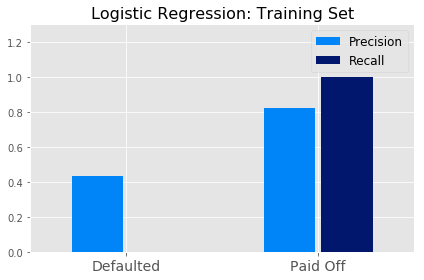

In [28]:
plot_results(targets_train,lr.predict(features_train[numerical]),'Logistic Regression: Training Set',schema='a')

#plt.savefig('./report/baseline-lr-train.jpg')

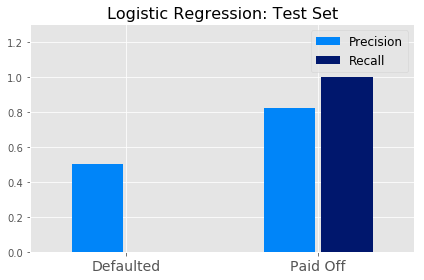

In [29]:
plot_results(targets_test,lr.predict(features_test[numerical]),'Logistic Regression: Test Set',schema='a')

#plt.savefig('./report/baseline-lr-test.jpg')

In [30]:
# the negative class represents 17.7% of the training set and 11.5% of the test set
# yet, the model outputs the negative class < 1% of the time

print(((targets_train-1).sum()*-1)/(targets_train.sum()+((targets_train-1).sum()*-1)))
print(((targets_test-1).sum()*-1)/(targets_test.sum()+((targets_train-1).sum()*-1)))
print(((lr.predict(features_test[numerical])-1).sum()*-1)/\
      ((lr.predict(features_test[numerical])).sum()+((lr.predict(features_test[numerical])-1).sum()*-1)))

0.17722171040248844
0.11547365017782088
7.92487221144e-05


In [31]:
# the true negative rate is extremely low. however, the model's precision on negative cases is a lot higher (50%)
# it seems the model very rarely outputs negative cases..yet when it does, it's still only correct half of the time

tn, fp, fn, tp = confusion_matrix(targets_train,lr.predict(features_train[numerical])).ravel()
TNR = tn/len(targets_train[targets_train==0])
TNR

0.00036333147009502513

---
## Other Models' Baseline Performance (no hyperparameter optimization - defaults used)

In [32]:
# Gaussian Naive Bayes has a slightly lower accuracy

from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(features_train[numerical],targets_train)
print(accuracy_score(GNB.predict(features_test[numerical]),targets_test))
print('')

# the recall on negative classes with Gaussian NB is significantly better than with Logistic Regression

print('TRAIN GNB')
print(classification_report(targets_train,GNB.predict(features_train[numerical])))
print('TEST GNB')
print(classification_report(targets_test,GNB.predict(features_test[numerical])))

# Gaussian NB seems much more sensitive to negative class predictions. it performs better than Logistic Regression, but
# there is still much room for improvement in recall of the negative class

print('test set negative class predictions: '+str((GNB.predict(features_test[numerical])-1).sum()*-1))
print('test set positive class predictions: '+str((GNB.predict(features_test[numerical])).sum()))

# Gaussian NB seems to have the best recall. flag datapoints using Gaussian NB and input into another model for the final
# prediction? apply predictive ML algorithms in a pipeline this way--ensemble method in series rather than in parallel

0.764789792765

TRAIN GNB
             precision    recall  f1-score   support

          0       0.33      0.31      0.32     35780
          1       0.85      0.87      0.86    166114

avg / total       0.76      0.77      0.76    201894

TEST GNB
             precision    recall  f1-score   support

          0       0.33      0.31      0.32      8929
          1       0.85      0.86      0.86     41545

avg / total       0.76      0.76      0.76     50474

test set negative class predictions: 8443
test set positive class predictions: 42031


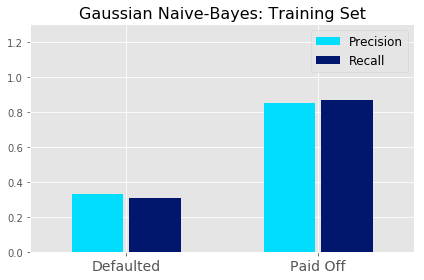

In [33]:
plot_results(targets_train,GNB.predict(features_train[numerical]),'Gaussian Naive-Bayes: Training Set',schema='b')

#plt.savefig('./report/baseline-gnb-train.jpg')

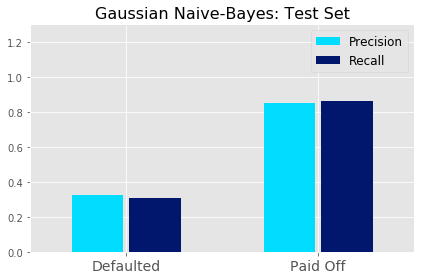

In [34]:
plot_results(targets_test,GNB.predict(features_test[numerical]),'Gaussian Naive-Bayes: Test Set',schema='b')

#plt.savefig('./report/baseline-gnb-test.jpg')

In [35]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier()
kNN.fit(features_train[numerical],targets_train)
print(accuracy_score(kNN.predict(features_test[numerical]),targets_test))
print('')

# the recall on negative classes with kNN is in between Logistic Regression and Gaussian NB

print('TRAIN kNN')
print(classification_report(targets_train,kNN.predict(features_train[numerical])))
print('TEST kNN')
print(classification_report(targets_test,kNN.predict(features_test[numerical])))

# kNN has very good recall on positive classes.. perhaps an ensemble method will provide the best result
# between recall and precision of both classes

print('test set negative class predictions: '+str((kNN.predict(features_test[numerical])-1).sum()*-1))
print('test set positive class predictions: '+str((kNN.predict(features_test[numerical])).sum()))

0.793695764156

TRAIN kNN
             precision    recall  f1-score   support

          0       0.63      0.19      0.29     35780
          1       0.85      0.98      0.91    166114

avg / total       0.81      0.84      0.80    201894

TEST kNN
             precision    recall  f1-score   support

          0       0.23      0.07      0.11      8929
          1       0.83      0.95      0.88     41545

avg / total       0.72      0.79      0.75     50474

test set negative class predictions: 2742
test set positive class predictions: 47732


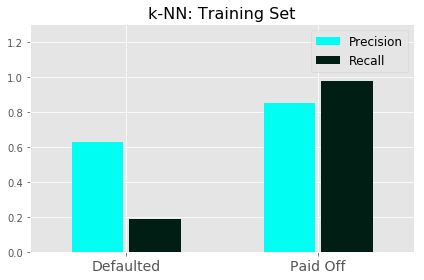

In [36]:
plot_results(targets_train,kNN.predict(features_train[numerical]),'k-NN: Training Set',schema='c')

#plt.savefig('./report/baseline-knn-train.jpg')

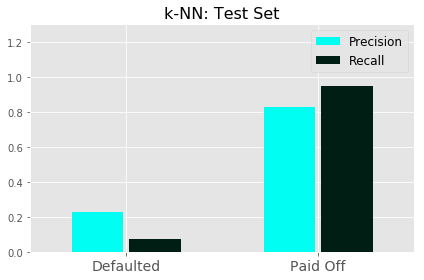

In [37]:
plot_results(targets_test,kNN.predict(features_test[numerical]),'k-NN: Test Set',schema='c')

#plt.savefig('./report/baseline-knn-test.jpg')

In [38]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier().fit(features_train[numerical],targets_train)
print(accuracy_score(RF.predict(features_test[numerical]),targets_test))
print('')

# Random Forest has very good overall performance on the training set, but much worse performance on the test set
# (overfitted..? tuning hyperparameters should help performance on test set)

print('TRAIN RF')
print(classification_report(targets_train,RF.predict(features_train[numerical])))
print('TEST RF')
print(classification_report(targets_test,RF.predict(features_test[numerical])))

# sensitivity to negative class predictions seem somewhere between Gaussian NB and kNN

print('test set negative class predictions: '+str((RF.predict(features_test[numerical])-1).sum()*-1))
print('test set positive class predictions: '+str((RF.predict(features_test[numerical])).sum()))

0.793200459643

TRAIN RF
             precision    recall  f1-score   support

          0       0.99      0.96      0.98     35780
          1       0.99      1.00      1.00    166114

avg / total       0.99      0.99      0.99    201894

TEST RF
             precision    recall  f1-score   support

          0       0.32      0.15      0.21      8929
          1       0.84      0.93      0.88     41545

avg / total       0.75      0.79      0.76     50474

test set negative class predictions: 4217
test set positive class predictions: 46257


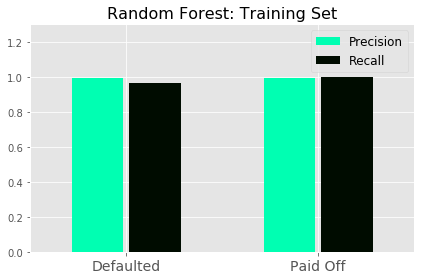

In [39]:
plot_results(targets_train,RF.predict(features_train[numerical]),'Random Forest: Training Set',schema='d')

#plt.savefig('./report/baseline-rf-train.jpg')

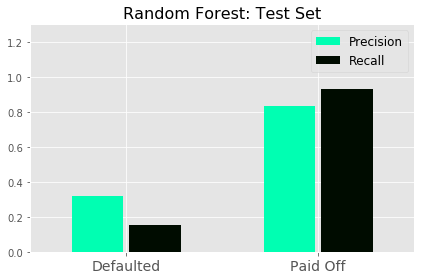

In [40]:
plot_results(targets_test,RF.predict(features_test[numerical]),'Random Forest: Test Set',schema='d')

#plt.savefig('./report/baseline-rf-test.jpg')

In [41]:
def plot_results_all(targets,predictions,title,schema='a'):

    tn, fp, fn, tp = confusion_matrix(targets,predictions).ravel()

    N_pre = tn/(tn+fn)
    N_rec = tn/(tn+fp)
        
    P_pre = tp/(tp+fp)
    P_rec = tp/(tp+fn)

    pre = [N_pre,P_pre]
    rec = [N_rec,P_rec]
    
    if schema == 'a':
        color1 = '#0085f9'
        color2 = '#00176d'
        
    if schema == 'b':
        color1 = '#00ddff'
        color2 = '#00176d'
        
    if schema == 'c':
        color1 = '#00fff2'
        color2 = '#001e14'
    
    if schema == 'd':
        color1 = '#00ffb2'
        color2 = '#000c00'

    k = 0.05
    ax.bar([2+k,5+k],pre,color=color1)
    ax.bar([3-k,6-k],rec,color=color2)
    ax.set_xticks([2.5,5.5])
    ax.set_xticklabels(['Defaulted','Paid Off'],fontsize=14)
    ax.set_xlim([1,7])
    ax.set_ylim([0,1.3])
    ax.legend(['Precision','Recall'],fontsize=12)
    ax.set_title(title,fontsize=16)

    plt.tight_layout()

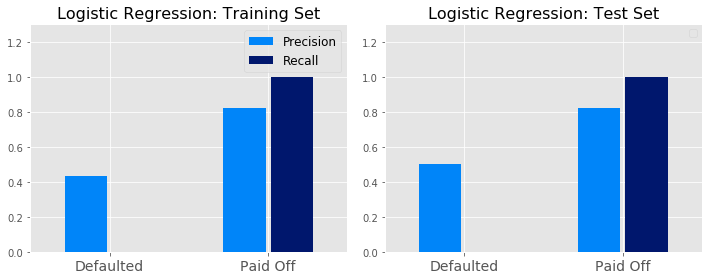

In [58]:
# to flatten the images together (for the report)

fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(1,2,1)
plot_results_all(targets_train,lr.predict(features_train[numerical]),'Logistic Regression: Training Set',schema='a')

ax = fig.add_subplot(1,2,2)
plot_results_all(targets_test,lr.predict(features_test[numerical]),'Logistic Regression: Test Set',schema='a')
ax.legend([])

#plt.savefig('./report/lr-baseline.jpg')

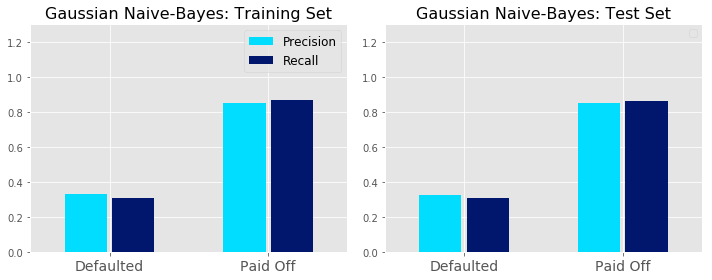

In [57]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(1,2,1)
plot_results_all(targets_train,GNB.predict(features_train[numerical]),'Gaussian Naive-Bayes: Training Set',schema='b')

ax = fig.add_subplot(1,2,2)
plot_results_all(targets_test,GNB.predict(features_test[numerical]),'Gaussian Naive-Bayes: Test Set',schema='b')
ax.legend([])

#plt.savefig('./report/gnb-baseline.jpg')

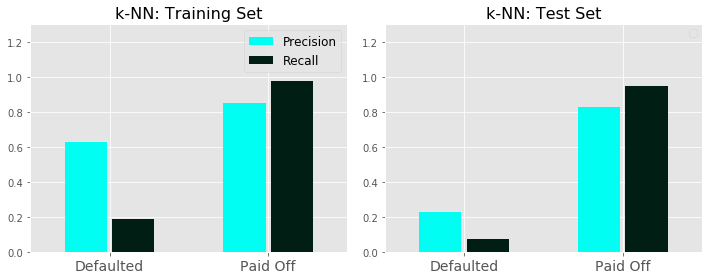

In [56]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(1,2,1)
plot_results_all(targets_train,kNN.predict(features_train[numerical]),'k-NN: Training Set',schema='c')

ax = fig.add_subplot(1,2,2)
plot_results_all(targets_test,kNN.predict(features_test[numerical]),'k-NN: Test Set',schema='c')
ax.legend([])

#plt.savefig('./report/knn-baseline.jpg')

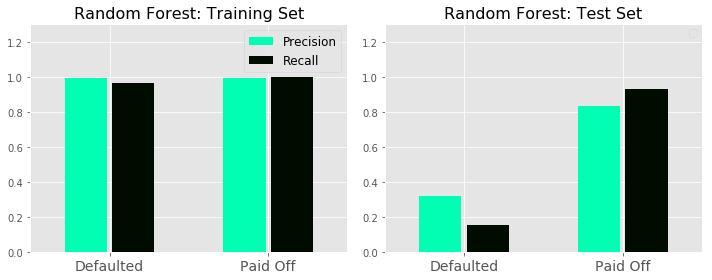

In [55]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(1,2,1)
plot_results_all(targets_train,RF.predict(features_train[numerical]),'Random Forest: Training Set',schema='d')

ax = fig.add_subplot(1,2,2)
plot_results_all(targets_test,RF.predict(features_test[numerical]),'Random Forest: Test Set',schema='d')
ax.legend([])

#plt.savefig('./report/rf-baseline.jpg')

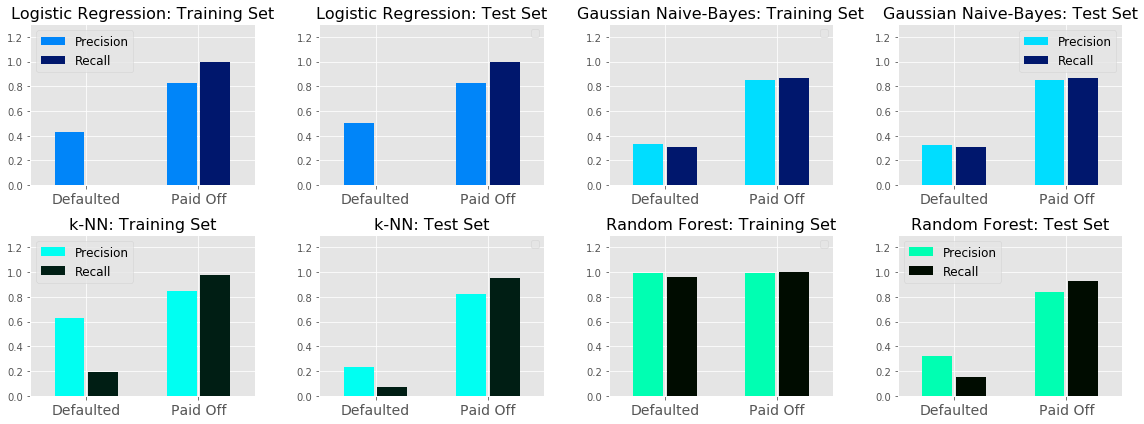

In [67]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(2,4,1)
plot_results_all(targets_train,lr.predict(features_train[numerical]),'Logistic Regression: Training Set',schema='a')

ax = fig.add_subplot(2,4,2)
plot_results_all(targets_test,lr.predict(features_test[numerical]),'Logistic Regression: Test Set',schema='a')
ax.legend([])

ax = fig.add_subplot(2,4,3)
plot_results_all(targets_train,GNB.predict(features_train[numerical]),'Gaussian Naive-Bayes: Training Set',schema='b')
ax.legend([])

ax = fig.add_subplot(2,4,4)
plot_results_all(targets_test,GNB.predict(features_test[numerical]),'Gaussian Naive-Bayes: Test Set',schema='b')

ax = fig.add_subplot(2,4,5)
plot_results_all(targets_train,kNN.predict(features_train[numerical]),'k-NN: Training Set',schema='c')

ax = fig.add_subplot(2,4,6)
plot_results_all(targets_test,kNN.predict(features_test[numerical]),'k-NN: Test Set',schema='c')
ax.legend([])

ax = fig.add_subplot(2,4,7)
plot_results_all(targets_train,RF.predict(features_train[numerical]),'Random Forest: Training Set',schema='d')
ax.legend([])

ax = fig.add_subplot(2,4,8)
plot_results_all(targets_test,RF.predict(features_test[numerical]),'Random Forest: Test Set',schema='d')

plt.tight_layout()
#plt.savefig('./report/baseline-all.jpg')

In [46]:
# conclusion: the LR model first appears to perform well (good accuracy) because there are an excessive number of positive cases
# in the data set. the model outputs positive predictions often and does it well, but misses almost all of the negative cases
# the model is insensitive to the negative class because the negative class has many feature values similar to the positive
# class, making them very difficult for the model to detect. 

# other ML models offer a much better balance, with significantly better recall on the negative class for slight reductions
# in accuracy

# it seems the next step is to make the model more sensitive to negative class predictions. this will likely come at the cost of
# reduction in recall for the positive class. the goal will be to increase negative class precision/recall without excessive
# reduction of precision/recall of the positive class

---